In [1]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import pandas as pd

In [2]:
df = pd.read_csv("obat_alodokter_new.csv")
df.head()
df_obat_for_eval = df.drop(['nama_obat'],axis=1)

In [3]:
import re

def clean_text(text):
    text = re.sub(r'\n+', ' ', text)  # hapus banyak \n
    text = re.sub(r'\s+', ' ', text)   # hapus spasi berlebihan
    return text.strip()

df['cleaned_reference'] = df['content'].apply(clean_text)

df['generated_text'] = df['cleaned_reference'].apply(lambda x: x.lower())

In [4]:
df_obat_for_bleu = df.drop(['nama_obat','generated_text','content'],axis=1)
df_obat_for_ndcg = df.drop(['generated_text','content'],axis=1)

In [5]:
df_obat_for_bleu

,cleaned_reference
0,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin Zoralin adalah tablet antijamur berbah...
...,...
2168,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [6]:
df_obat_for_ndcg

,nama_obat,cleaned_reference
0,Zyloric,Zyloric Zyloric adalah obat untuk menurunkan k...
1,Zovirax Krim,Zovirax Krim Zovirax krim adalah obat oles yan...
2,Zovigen,Zovigen Zovigen adalah obat oles yang bermanfa...
3,Zoralin Krim,Zoralin Krim Zoralin krim adalah obat oles unt...
4,Zoralin,Zoralin Zoralin adalah tablet antijamur berbah...
...,...,...
2168,Acarbose,Acarbose Acarbose adalah obat untuk menurunkan...
2169,Acalabrutinib,Acalabrutinib Acalabrutinib adalah obat kemote...
2170,Abrocitinib,Abrocitinib Abrocitinib adalah obat untuk meng...
2171,Abemaciclib,Abemaciclib Abemaciclib adalah obat kemoterapi...


In [7]:
import pandas as pd
import json

def format_result_to_text(user_data):
    formatted_text = ""
    for idx, record in enumerate(user_data['agent']):
        nomor = idx + 1  
        formatted_text += f"{nomor}. Rekomendasi obat:\n"
        formatted_text += f" - {record.get('nama_obat')} Dosis: {record.get('dosis')}\n"
        formatted_text += f"   Aturan pakai: {record.get('aturan_pakai', 'Aturan Pakai Tidak Tersedia')}\n"
        formatted_text += f"   Efek samping: {record.get('efek_samping_obat', 'Efek Samping Tidak Tersedia')}\n\n"
    return formatted_text.strip()

with open('memory.json', 'r') as file:
    data = json.load(file)

df_obat_for_bleu = pd.DataFrame({
    'generated_text': [None] * 4 
})

user_id = "7116300622"
if user_id in data:
    user_data = data[user_id][0] 
    formatted_text = format_result_to_text(user_data)
    
    df_obat_for_bleu.loc[0, 'generated_text'] = formatted_text


In [8]:
bleu_scores = []
rouge_scores = []

rouge = Rouge()

In [9]:
for idx, row in df.iterrows():
    reference = [row['cleaned_reference'].split()]  # list of list
    candidate = row['generated_text'].split()

    # Hitung BLEU
    bleu = sentence_bleu(reference, candidate)
    bleu_scores.append(bleu)

    # Hitung ROUGE
    rouge_score = rouge.get_scores(row['generated_text'], row['cleaned_reference'])[0]
    rouge_scores.append(rouge_score)

# Rata-rata skor
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge_1 = sum([r['rouge-1']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_2 = sum([r['rouge-2']['f'] for r in rouge_scores]) / len(rouge_scores)
avg_rouge_l = sum([r['rouge-l']['f'] for r in rouge_scores]) / len(rouge_scores)

print("Average BLEU:", avg_bleu)
print("Average ROUGE-1:", avg_rouge_1)
print("Average ROUGE-2:", avg_rouge_2)
print("Average ROUGE-L:", avg_rouge_l)

Average BLEU: 0.6563175584020436
Average ROUGE-1: 0.8320645836767182
Average ROUGE-2: 0.710628568721906
Average ROUGE-L: 0.8320645836767182


In [10]:
import math

def dcg(relevances):
    return sum((rel / math.log2(i + 2)) for i, rel in enumerate(relevances))

def compute_ndcg_at_k(true_relevant, recommended_items, k=5):
    recommended_items_k = recommended_items[:k]

    relevance_scores = [1 if item in true_relevant else 0 for item in recommended_items_k]

    actual_dcg = dcg(relevance_scores)

    ideal_relevance = sorted(relevance_scores, reverse=True)
    ideal_dcg = dcg(ideal_relevance)

    if ideal_dcg == 0:
        return 0.0

    return actual_dcg / ideal_dcg

In [11]:
ndcg_scores = []

true_relevant_list = [
    ['Loratadine', 'Cetirizine', 'Alloris','Lerzin','Claritin','Incidal'] ,  
    ['Isoniazid', 'Rifampicin', 'Pro TB-4','Pro TB-2','Pyrazinamide'] ,                        
    ['Warfarin', 'Rivaroxaban', 'Dabigatran','Apixaban','Edoxaban','Heparin'],
    ['Olopatadine', 'Azelastin', 'Ketotifen','Dekongestan'],
    ['Besi elemental (garam besi)', 'Ferrous Sulfate', 'Ferrous Fumarate','Ferrous Gluconate','Heme iron polypeptide','Iron polysaccharide'] 
]

recommended_items_list = [
    ['Cetirizine', 'Loratadine', 'Prednison', 'Diphenhydramine', 'Hydroxyzine'] ,
    ['Rifampicin', 'Isoniazid', 'Pyrazinamide', 'Ethambutol', 'Streptomisin'] ,
    ['Heparin', 'Warfarin', 'Edoxaban', 'Enoxaparin', 'Rivaroxaban'] ,
    ['Olopatadine', 'Cetirizine', 'Loratadine', 'saline', 'Antazoline'] ,
    ['Ferrous Sulfate', 'Ferrous Gluconate', 'Ferrous Fumarate', 'Iron Sucrose', 'Polysaccharide Iron Complex']
]

for true_relevant, recommended_items in zip(true_relevant_list, recommended_items_list):
    ndcg = compute_ndcg_at_k(true_relevant, recommended_items, k=5)
    ndcg_scores.append(ndcg)

print(ndcg_scores)

[1.0, 1.0, 0.9828920819566879, 1.0, 1.0]


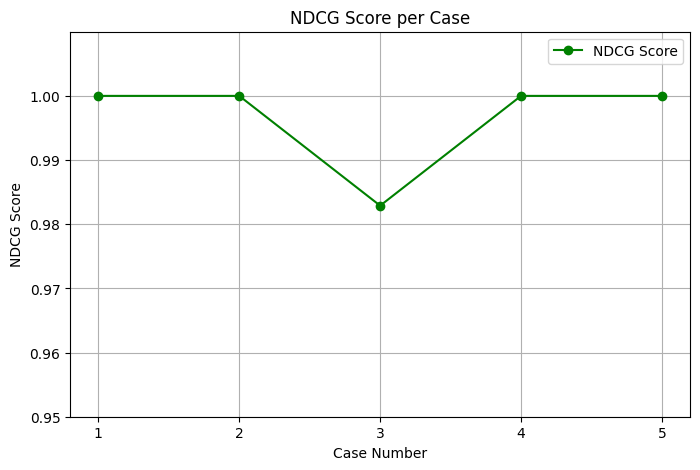

In [12]:
import matplotlib.pyplot as plt

# Data
ndcg_scores = [1.0, 1.0, 0.9828920819566879, 1.0, 1.0]
cases = list(range(1, len(ndcg_scores) + 1))

# Buat grafik garis
plt.figure(figsize=(8, 5))
plt.plot(cases, ndcg_scores, marker='o', linestyle='-', color='green', label='NDCG Score')
plt.xticks(cases)
plt.ylim(0.95, 1.01)  # Fokus ke skor tinggi
plt.yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

# Label dan judul
plt.xlabel('Case Number')
plt.ylabel('NDCG Score')
plt.title('NDCG Score per Case')
plt.grid(True)
plt.legend()

# Tampilkan grafik
plt.show()


In [15]:
import numpy as np

scores = {
    "Bleu" : avg_bleu,
    "Rouge-1" : avg_rouge_1,
    "Rouge-2" : avg_rouge_2,
    "Rouge-L" : avg_rouge_l,
    "NDCG" : np.mean(ndcg_scores)
}

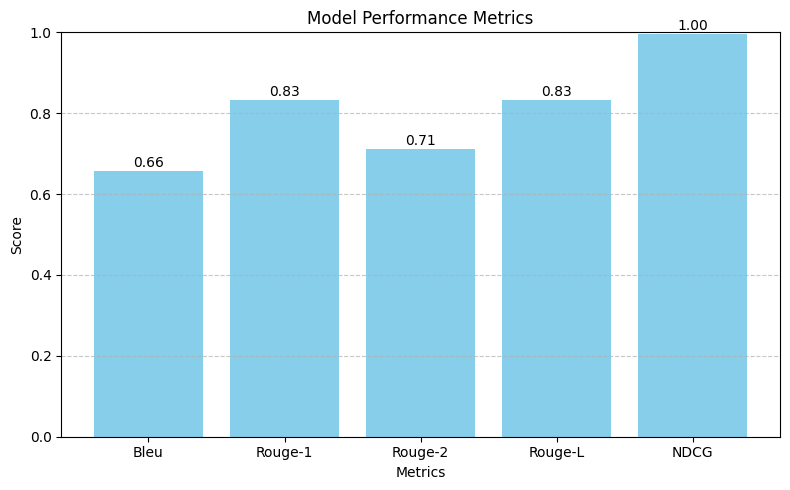

In [16]:
import matplotlib.pyplot as plt

# Data
metrics = list(scores.keys())
values = list(scores.values())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='skyblue')

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

# Label dan judul
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
